In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

from ISLP.models import ModelSpec as MS

from statsmodels.datasets import get_rdataset

import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import LinearRegression

from sklearn.multioutput import MultiOutputRegressor

from sklearn.decomposition import PCA

from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)

from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   StandardScaler)

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import (accuracy_score,
                             log_loss)

from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)

In [2]:
patch_fidelity = pd.read_csv('data.patch.fidelity.csv')
patch_fidelity.dtypes

year              int64
tagged.date      object
tagged.time      object
tagged.patch     object
sighted.date     object
sighted.time     object
sighted.patch    object
site             object
tag              object
bee.species      object
color            object
number            int64
pollen.sac       object
dtype: object

In [3]:
honey = pd.read_csv('EcobeeHoney.txt', delimiter="\t")
print(honey.dtypes)

Site          object
Rapeseed     float64
Sunflower    float64
dtype: object


In [4]:
colony_dynamic = pd.read_csv('EcobeeColonyDynamic.txt', delimiter="\t")
colony_dynamic.dtypes

Site             object
Date              int64
PopSize         float64
WorkerBrood     float64
DroneBrood      float64
HoneyReserve    float64
Varroa          float64
dtype: object

In [5]:
stress = pd.read_csv('EcobeeStress.txt', delimiter="\t")
stress.dtypes

Site        int64
Stress    float64
NA         object
dtype: object

In [6]:
survival = pd.read_csv('EcobeeSurvival.txt', delimiter="\t")
survival.dtypes

Site               object
SummerSurvival    float64
WinterSurvival    float64
AnnualSurvival    float64
dtype: object

In [7]:
std_varroa = colony_dynamic['Varroa'].std()
std_varroa

20.542191474633483

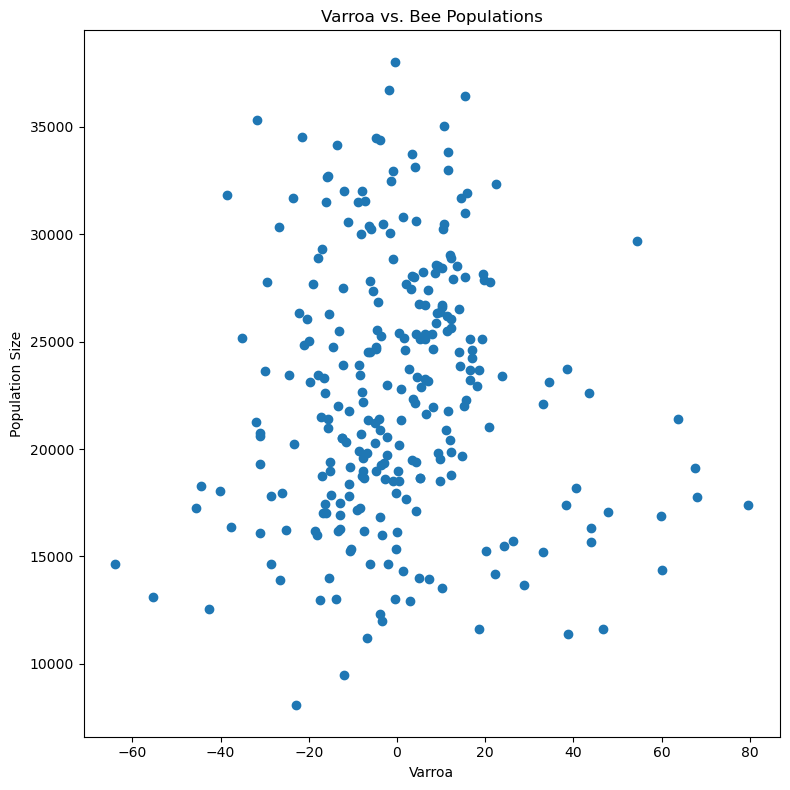

In [8]:
# Scatter Plot for Varroa compared to Bee Populations

fig, ax = subplots(figsize=(8, 8))
x = colony_dynamic['Varroa']
y = colony_dynamic['PopSize']

plt.scatter(x, y)
plt.xlabel('Varroa')
plt.ylabel('Population Size')
plt.title('Varroa vs. Bee Populations')
plt.tight_layout()
plt.savefig("varroa_v_bees.png", dpi=200)
plt.show()

# make tree for this one: output - varroa

MSE for Decision Tree: 370.8688306738472
RMSE for Decision Tree: 19.257954997191348


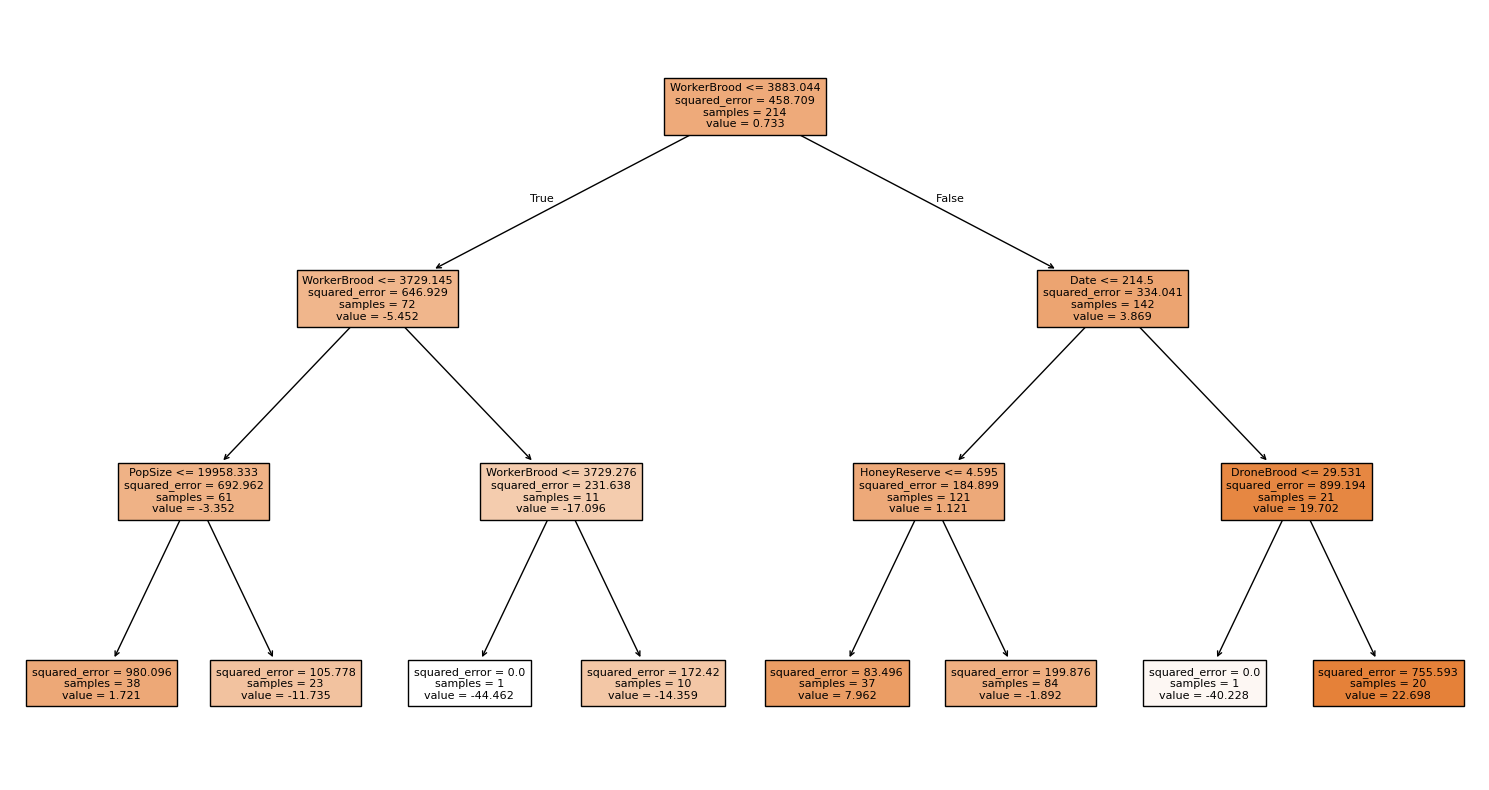

In [9]:
# Decision Tree for Predicting Varroa

colony_dynamic['Site'] = LabelEncoder().fit_transform(colony_dynamic['Site'])

colony_dynamic.dropna(inplace=True)

X = colony_dynamic[['Site',
                    'Date',
                    'PopSize',
                    'WorkerBrood',
                    'DroneBrood',
                    'HoneyReserve']]
y = colony_dynamic['Varroa']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

tree_model = DTR(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

tree_mse = mean_squared_error(y_test, y_pred)
tree_rmse = tree_mse**0.5

print("MSE for Decision Tree:", tree_mse)
print("RMSE for Decision Tree:", tree_rmse)

plt.figure(figsize=(15, 8))
plot_tree(tree_model,
          feature_names=X.columns,
          filled=True,
          fontsize=8)
plt.tight_layout()
plt.savefig("tree_model.png", dpi=300)
plt.show()

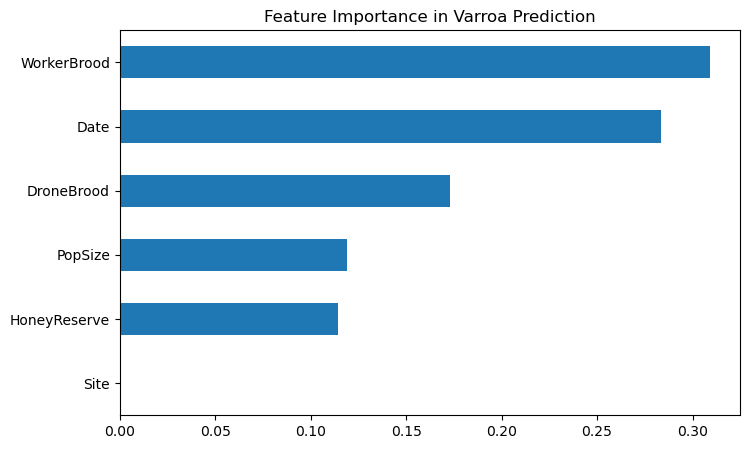

In [10]:
# Feature Importance for Decision Tree Model

feat_importance = pd.Series(tree_model.feature_importances_,
                            index=X.columns)
feat_importance.sort_values().plot(kind="barh",
                                   title="Feature Importance in Varroa Prediction",
                                   figsize=(8, 5))
plt.show()

In [11]:
# Trying to export the text form of the tree

tree_rules = export_text(tree_model,
                         feature_names=list(X.columns))
tree_rules

'|--- WorkerBrood <= 3883.04\n|   |--- WorkerBrood <= 3729.14\n|   |   |--- PopSize <= 19958.33\n|   |   |   |--- value: [1.72]\n|   |   |--- PopSize >  19958.33\n|   |   |   |--- value: [-11.73]\n|   |--- WorkerBrood >  3729.14\n|   |   |--- WorkerBrood <= 3729.28\n|   |   |   |--- value: [-44.46]\n|   |   |--- WorkerBrood >  3729.28\n|   |   |   |--- value: [-14.36]\n|--- WorkerBrood >  3883.04\n|   |--- Date <= 214.50\n|   |   |--- HoneyReserve <= 4.60\n|   |   |   |--- value: [7.96]\n|   |   |--- HoneyReserve >  4.60\n|   |   |   |--- value: [-1.89]\n|   |--- Date >  214.50\n|   |   |--- DroneBrood <= 29.53\n|   |   |   |--- value: [-40.23]\n|   |   |--- DroneBrood >  29.53\n|   |   |   |--- value: [22.70]\n'

In [12]:
# Cross validation using tree model

colony_dynamic['Site'] = LabelEncoder().fit_transform(colony_dynamic['Site'])

colony_dynamic.dropna(inplace=True)

X = colony_dynamic[['Site',
                    'Date',
                    'PopSize',
                    'WorkerBrood',
                    'DroneBrood',
                    'HoneyReserve']]
y = colony_dynamic['Varroa']

kf = KFold(n_splits=10, 
           shuffle=True, 
           random_state=42)

tree_model = DTR(max_depth=3,
                 random_state=42)

cv_scores = cross_val_score(tree_model,
                            X,
                            y,
                            cv=kf,
                            scoring="neg_mean_squared_error")

mse_tree = -cv_scores
rmse_tree = mse_tree ** 0.5

print ("mse scores: ", mse_tree)
print("rmse scores: ", rmse_tree)

avg_mse_tree = mse_tree.mean()
avg_rmse_tree = rmse_tree.mean()

print("average mse: ", avg_mse_tree)
print("average rmse: ", avg_rmse_tree)

mse scores:  [ 303.02666174  449.31422218  538.94397404  319.91535464  449.15800074
  262.98649012  204.62935259 1091.84101674  598.72472954  729.9231967 ]
rmse scores:  [17.40766101 21.19703333 23.2151669  17.88617775 21.19334803 16.21685821
 14.30487164 33.04301767 24.46885223 27.01709083]
average mse:  494.84629990165047
average rmse:  21.595007759573544


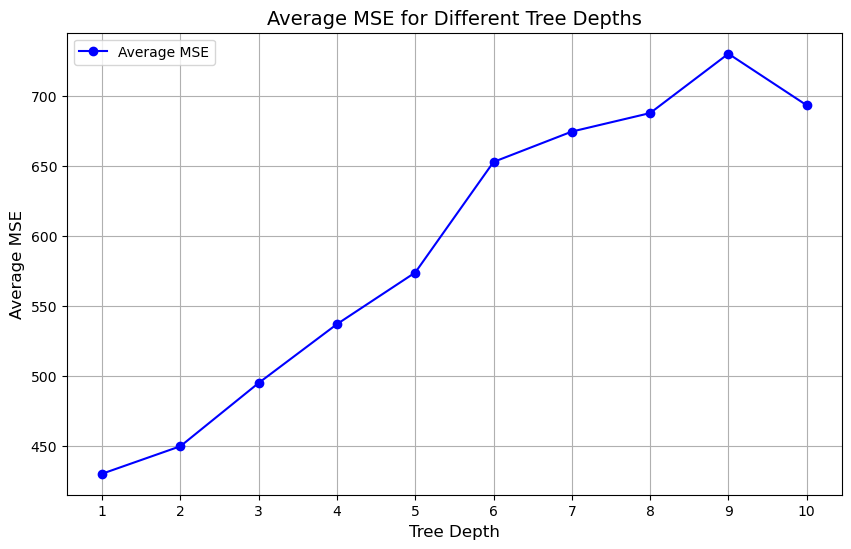

In [13]:
# plotting mse under cross-validation using tree levels

depths = range(1,11)
avg_mse = []

colony_dynamic.dropna(inplace=True)

X = colony_dynamic[['Site',
                    'Date',
                    'PopSize',
                    'WorkerBrood',
                    'DroneBrood',
                    'HoneyReserve']]

y = colony_dynamic['Varroa']

kf = KFold(n_splits=10,
           shuffle=True,
           random_state=42)

for depth in depths:
    tree_model = DTR(max_depth=depth, random_state=42)
    mse_scores = cross_val_score(tree_model, X, y, cv=kf, scoring='neg_mean_squared_error')
    avg_mse.append(-np.mean(mse_scores))

plt.figure(figsize=(10, 6))
plt.plot(depths, avg_mse, marker='o', color='b', label='Average MSE')
plt.title('Average MSE for Different Tree Depths', fontsize=14)
plt.xlabel('Tree Depth', fontsize=12)
plt.ylabel('Average MSE', fontsize=12)
plt.grid(True)
plt.xticks(depths)
plt.legend()
plt.show()

In [14]:
# random forest model

rf_model = RF(n_estimators=100,
              max_depth=3,
              random_state=42)
rf_model.fit(X_train, y_train)

y_rf_pred = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_rf_pred)
rmse_rf = mse_rf ** 0.5
print("mse: ", mse_rf, "rmse: ", rmse_rf)

mse:  284.1000369463171 rmse:  16.855267335355947


mse:  [ 281.06568163  334.51186211  471.41100445  360.0464623   361.64440166
  422.79010385  204.61936832 1031.87919683  403.49609408  579.42496242]
rmse:  [16.76501362 18.28966545 21.71200139 18.97489031 19.01695038 20.56186042
 14.30452265 32.12287653 20.0872122  24.07124763]
average mse:  445.08891376471456
average rmse:  20.590624058089656
standard deviation for varroa:  20.542191474633483
difference:  0.048432583456172296


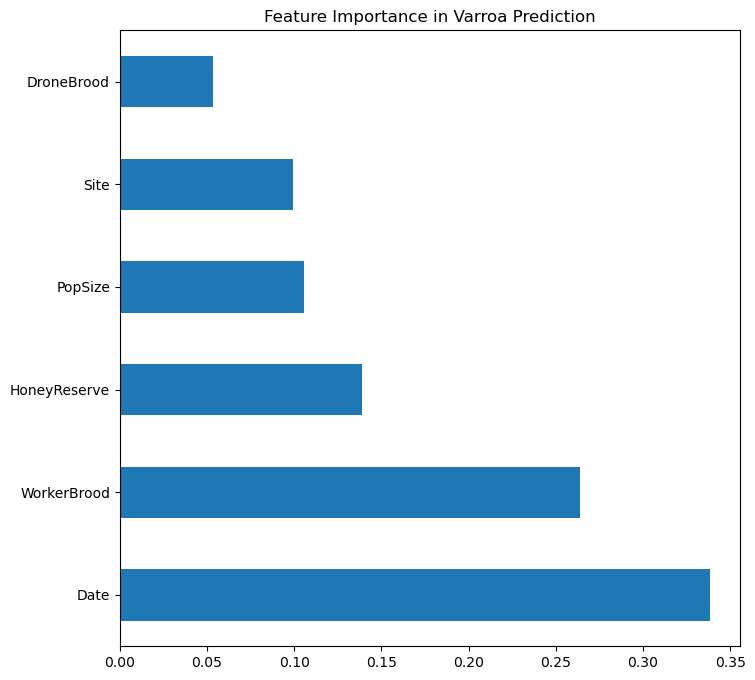

In [15]:
#cross validation using random forest

colony_dynamic.dropna(inplace=True)

X = colony_dynamic[['Site',
                    'Date',
                    'PopSize',
                    'WorkerBrood',
                    'DroneBrood',
                    'HoneyReserve']]
y = colony_dynamic['Varroa']

kf = KFold(n_splits=10, 
           shuffle=True, 
           random_state=42)

cv_scores = cross_val_score(rf_model,
                            X,
                            y,
                            cv=kf,
                            scoring="neg_mean_squared_error")

cv_mse_scores = -cv_scores
cv_rmse_scores = np.sqrt(cv_mse_scores)

print("mse: ", cv_mse_scores)
print("rmse: ", cv_rmse_scores)

mse_rf = cv_mse_scores.mean()
rmse_rf = cv_rmse_scores.mean()

print("average mse: ", mse_rf)
print("average rmse: ", rmse_rf)
print("standard deviation for varroa: ", 20.542191474633483)
print("difference: ", (rmse_rf-std_varroa))

# finding feature importance of random forest

feat_importance_rf = pd.Series(rf_model.feature_importances_,
                               index=X.columns)
feat_importance_rf.sort_values(ascending=False).plot(kind="barh",
                                      title="Feature Importance in Varroa Prediction",
                                      figsize=(8, 8))
plt.show()

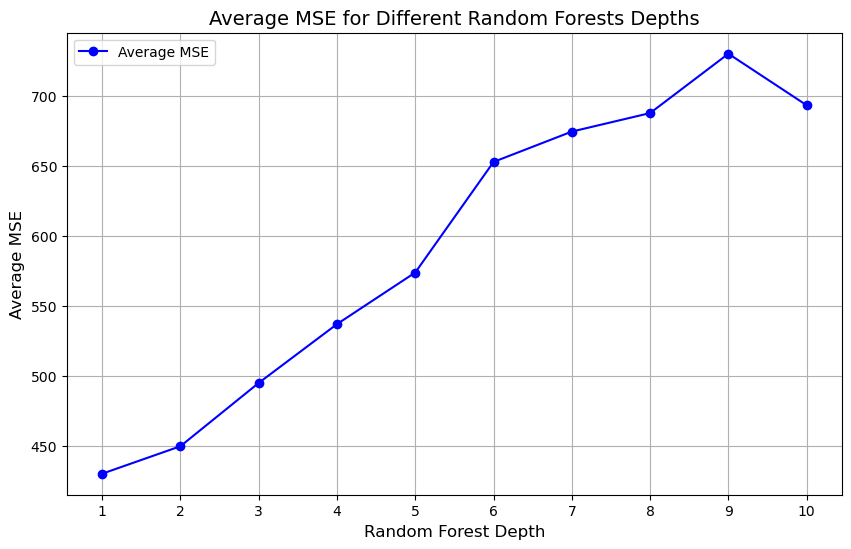

In [16]:
# validating random forest models

depths = range(1, 11)
avg_mse_rf = []
y = colony_dynamic['Varroa']

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for depth in depths:
    rf_model = DTR(max_depth=depth, random_state=42)
    mse_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')
    avg_mse_rf.append(-np.mean(mse_scores))

plt.figure(figsize=(10, 6))
plt.plot(depths, avg_mse, marker='o', color='b', label='Average MSE')
plt.title('Average MSE for Different Random Forests Depths', fontsize=14)
plt.xlabel('Random Forest Depth', fontsize=12)
plt.ylabel('Average MSE', fontsize=12)
plt.grid(True)
plt.xticks(depths)
plt.legend()
plt.show()

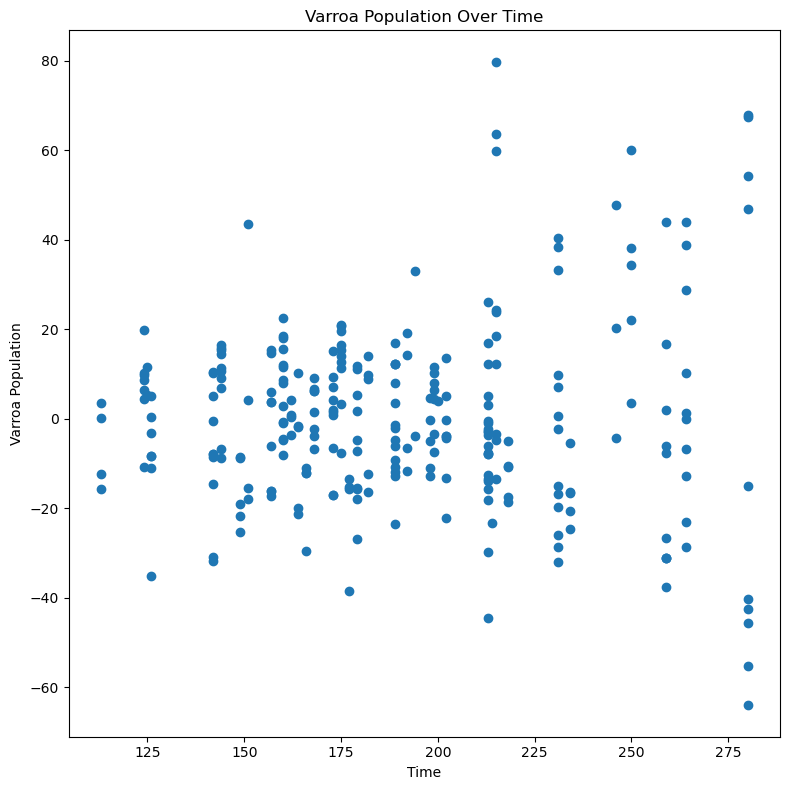

In [17]:
# graph of varroa by time based on feature importance
# of random forest

x = colony_dynamic['Date']
y = colony_dynamic['Varroa']

plt.figure(figsize=(8, 8))
plt.scatter(x, y)
plt.xlabel("Time")
plt.ylabel("Varroa Population")
plt.title("Varroa Population Over Time")
plt.tight_layout()
plt.savefig("varroa_pop_over_time.png", dpi=300)
plt.show()

In [18]:
# Multiple Linear Regression

colony_dynamic['Site'] = LabelEncoder().fit_transform(colony_dynamic['Site'])

colony_dynamic.dropna(inplace=True)
colony_dynamic["Varroa"] = colony_dynamic["Varroa"]

X = colony_dynamic[['Site',
                    'Date',
                    'PopSize',
                    'WorkerBrood',
                    'DroneBrood',
                    'HoneyReserve']]
y = colony_dynamic['Varroa']

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

y_pred = mlr_model.predict(X_test)

# evaluation

mse_mlr = mean_squared_error(y_test, y_pred)
rmse_mlr = np.sqrt(mse_mlr)
r2_mlr = r2_score(y_test, y_pred)

mlr_model_scaled = LinearRegression()
mlr_model_scaled.fit(X_train_scaled, y_train)

y_pred_scaled = mlr_model_scaled.predict(X_test_scaled)

mse_mlr_scaled = mean_squared_error(y_test, y_pred_scaled)
rmse_mlr_scaled = mse_mlr_scaled ** 0.5


print("MLR MSE: ", mse_mlr)
print("MLR RMSE: ", rmse_mlr)

print("MLR MSE after scaling:", mse_mlr_scaled)
print("MLR RMSE after scaling:", rmse_mlr_scaled)

MLR MSE:  256.67707914859255
MLR RMSE:  16.02114475150239
MLR MSE after scaling: 258.7760711315055
MLR RMSE after scaling: 16.08651830358283


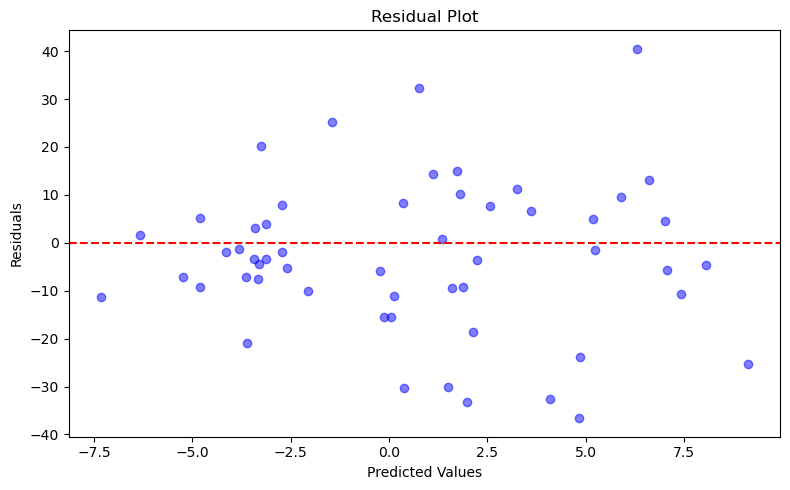

In [19]:
# visualizations of MLR

residuals = y_test-y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.savefig("residual_plot.png", dpi=300)
plt.show()

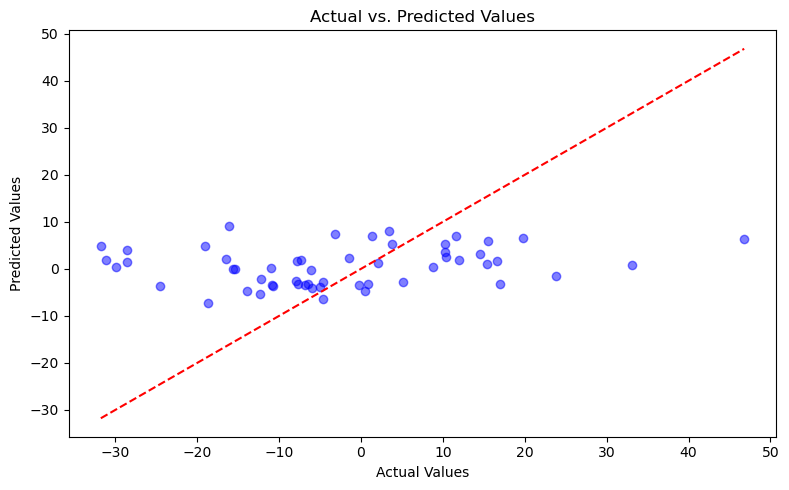

In [20]:
# actual vs predicted values

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.tight_layout()
plt.savefig("actual_predicted_values.png", dpi=300)
plt.show()

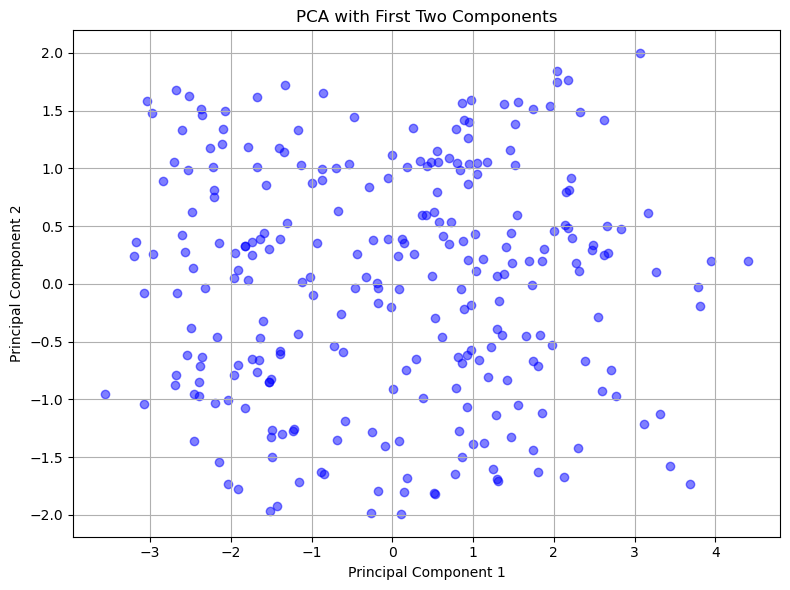

In [21]:
# PCA with date and workerbrood since they've the
# highest feature importance

selected_features = colony_dynamic[['Site', 
                                    'Date',
                                    'WorkerBrood', 
                                    'PopSize',
                                    'DroneBrood',
                                    'HoneyReserve']]

# standardizing the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

pca = PCA(n_components=len(selected_features.columns))
pca_transformed = pca.fit_transform(scaled_features)

length = len(selected_features.columns)

pca_df = pd.DataFrame(pca_transformed, columns=[f'PC{i+1}' for i in range(length)])

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, color='b')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with First Two Components')
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_two_comp.png")
plt.show()

In [22]:
# try and create comparisons of different PCA components later

Average MSE for PCA: 429.9974686352199
RMSE for PCA: 20.736380316613115


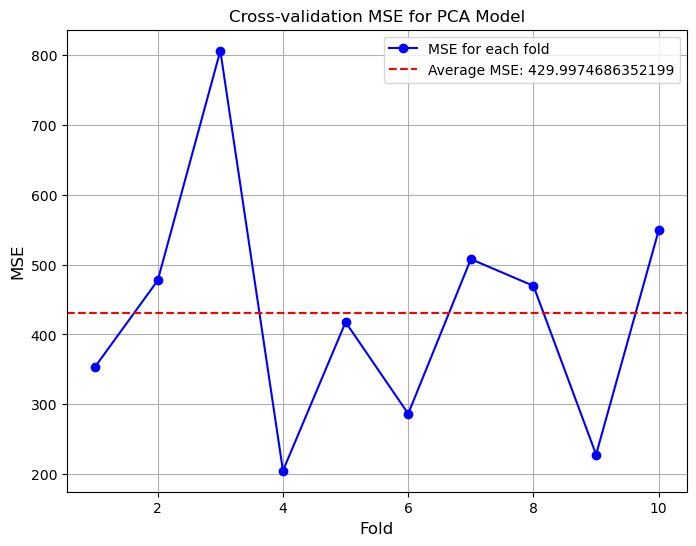

In [23]:
# cross-validation of PCA for average MSE:
# model built with linear regression

pca_model = LinearRegression()

mse_scores = -cross_val_score(pca_model, 
                              pca_transformed, 
                              y, 
                              cv=10, 
                              scoring='neg_mean_squared_error')
avg_mse_pca = np.mean(mse_scores)
rmse_pca = avg_mse_pca**0.5

print("Average MSE for PCA:", avg_mse_pca)
print("RMSE for PCA:", rmse_pca)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), mse_scores, marker='o', color='b', label='MSE for each fold')
plt.axhline(y=avg_mse_pca, color='r', linestyle='--', label=f'Average MSE: {avg_mse_pca:}')
plt.title('Cross-validation MSE for PCA Model')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

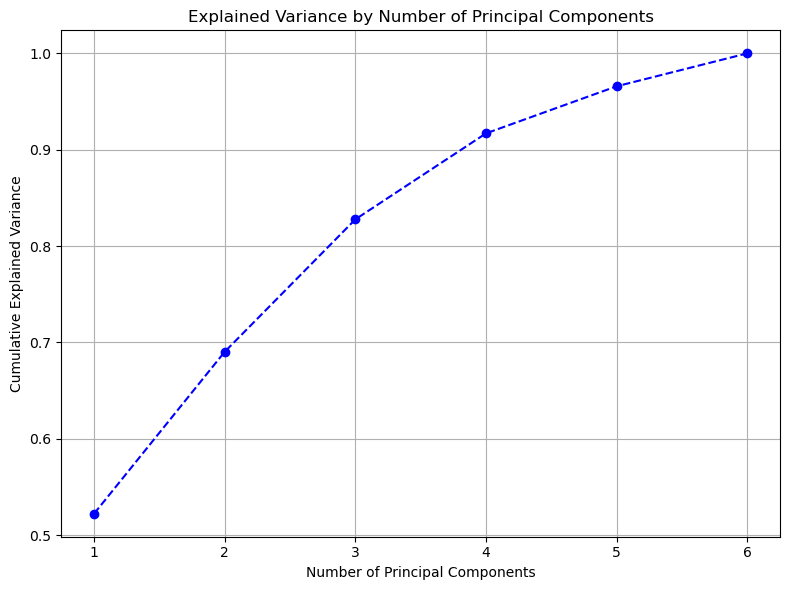

In [24]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1),
         explained_variance,
         marker='o',
         linestyle='--',
         color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.tight_layout()
plt.savefig("explained_variance_ratio.png", dpi=300)
plt.show()

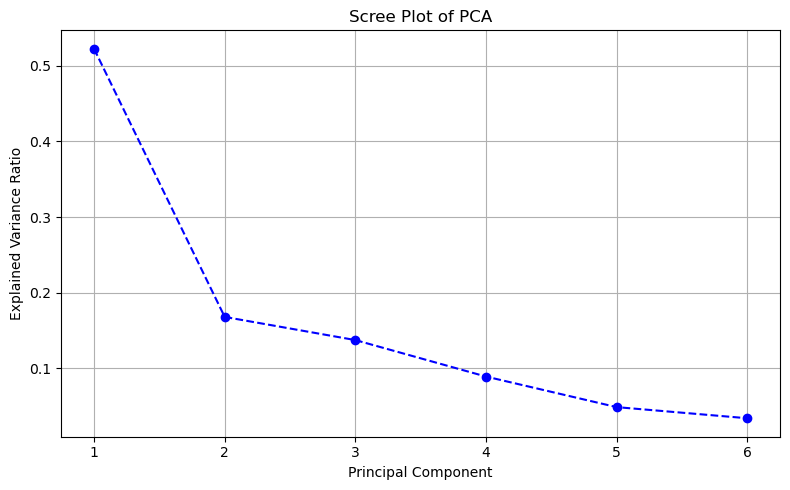

In [25]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1),
         explained_variance,
         marker='o',
         linestyle='--',
         color='b')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA')
plt.grid(True)
plt.tight_layout()
plt.savefig("scree_plot.png", dpi=300)
plt.show()

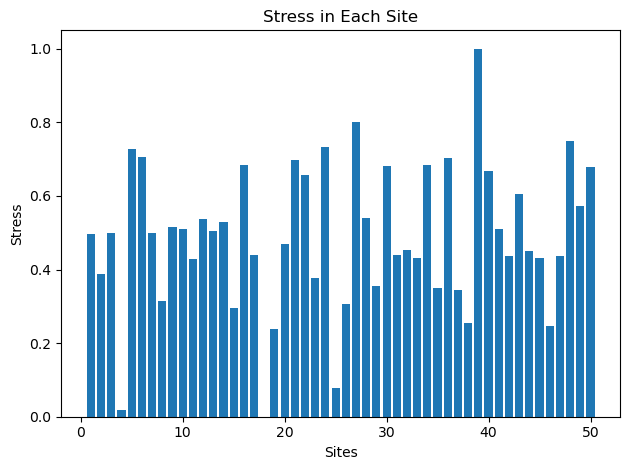

In [26]:
# Data Analysis for Stress

x = stress['Site']
y = stress['Stress']

plt.bar(x, y)
plt.xlabel('Sites')
plt.ylabel('Stress')
plt.title('Stress in Each Site')
plt.tight_layout()
plt.savefig("stress.png", dpi=300)
plt.show()

In [27]:
x = stress['Stress']

print("median: ", np.median(x))

median:  0.49759581788021146


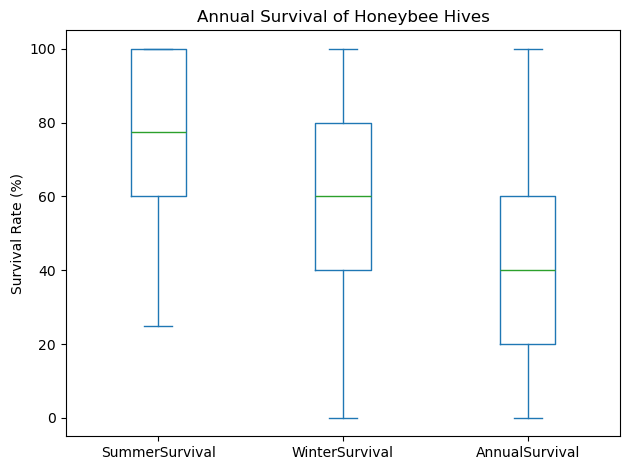

In [28]:
# Data Analysis for Survival

survival.plot.box()
plt.ylabel("Survival Rate (%)")
plt.title("Annual Survival of Honeybee Hives")
plt.tight_layout()
plt.savefig("annual_survival.png", dpi=300)

In [29]:
# Comparison table of models made so far

model_results = {
    "Model": ["Decision Tree", "Multiple Linear Regression", "Random Forest", "PCA"],
    "MSE": [tree_mse, mse_mlr, mse_rf, avg_mse_pca],
    "RMSE": [tree_rmse, rmse_mlr, rmse_rf, rmse_pca]
}

results_df = pd.DataFrame(model_results)
results_df

,Model,MSE,RMSE
0,Decision Tree,370.868831,19.257955
1,Multiple Linear Regression,256.677079,16.021145
2,Random Forest,445.088914,20.590624
3,PCA,429.997469,20.736380


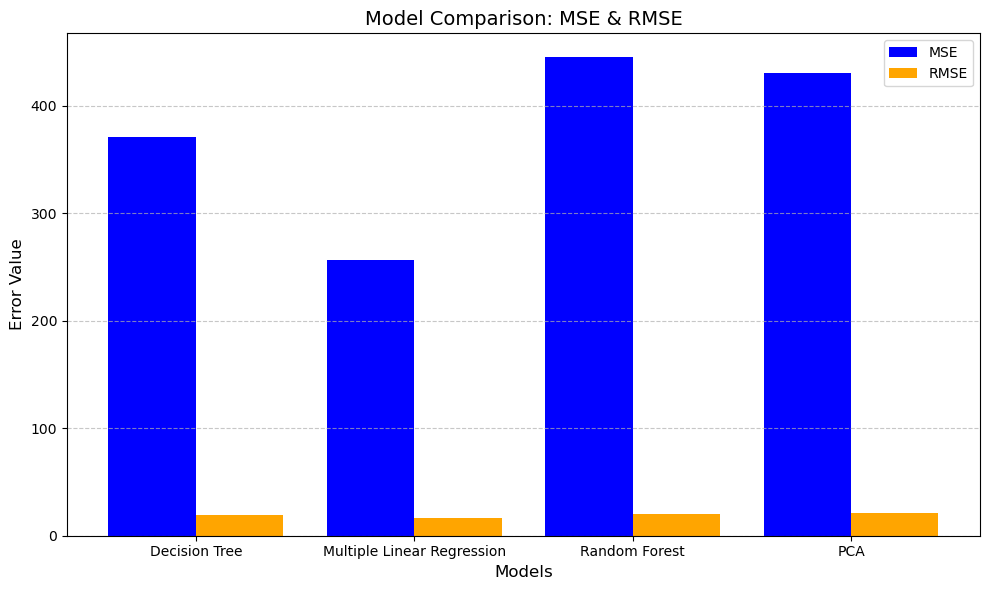

In [30]:
models = ["Decision Tree",
          "Multiple Linear Regression",
          "Random Forest",
          "PCA"]

mse_values = [tree_mse, mse_mlr, mse_rf, avg_mse_pca]
rmse_values = [tree_rmse, rmse_mlr, rmse_rf, rmse_pca]

x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
ax.bar(x - bar_width/2,
       mse_values,
       bar_width,
       label='MSE',
       color='blue')
ax.bar(x + bar_width/2,
       rmse_values,
       bar_width,
       label='RMSE',
       color='orange')

ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Error Value", fontsize=12)
ax.set_title("Model Comparison: MSE & RMSE", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)
plt.show()